In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
import tensorflow as tf
os.chdir('/content/drive/MyDrive/Summer22_ML Assignments')

#Importing Dataset
dataset_SeoulBikedata = pd.read_csv('SeoulBikeData.csv', encoding = 'latin-1')
dataset_SeoulBikedata.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


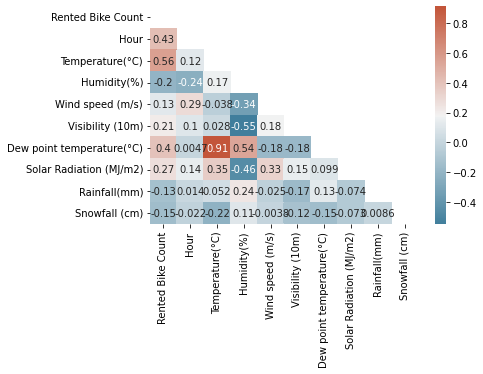

In [2]:
dataset_SeoulBikedata['Date'] = pd.to_datetime(dataset_SeoulBikedata['Date'], format="%d/%m/%Y")

dataset_SeoulBikedata = dataset_SeoulBikedata[dataset_SeoulBikedata['Functioning Day'] == 'Yes']
dataset_SeoulBikedata.reset_index(inplace = True)
dataset_SeoulBikedata.drop(columns = ['index','Functioning Day'],inplace = True)

dataset_SeoulBikedata['Day_or_night'] = (dataset_SeoulBikedata['Hour']).apply(lambda x: 'Night' if (x>19 or x<5)else ('Day'))
dataset_SeoulBikedata['Weekday'] = pd.DatetimeIndex(dataset_SeoulBikedata['Date']).day_name()

corrMatrix = dataset_SeoulBikedata.corr()
sn.heatmap(corrMatrix, annot=True, cmap = sn.diverging_palette(230, 20, as_cmap=True), mask = np.triu(np.ones_like(corrMatrix)))
sn.set(rc={'figure.figsize':(10,7.5)})

In [3]:
dataset_SeoulBikedata = dataset_SeoulBikedata.drop(columns = ['Dew point temperature(°C)'])

In [4]:
median_rented_bike_count = dataset_SeoulBikedata['Rented Bike Count'].median()
median_rented_bike_count

print('Number of rows with Rented bike count less than median value: ', 
      dataset_SeoulBikedata['Rented Bike Count'][dataset_SeoulBikedata['Rented Bike Count'] < median_rented_bike_count].count())
print('Number of rows with Rented bike count greater than median value: ', 
      dataset_SeoulBikedata['Rented Bike Count'][dataset_SeoulBikedata['Rented Bike Count'] > median_rented_bike_count].count())

Number of rows with Rented bike count less than median value:  4229
Number of rows with Rented bike count greater than median value:  4231


In [5]:
#Converting Target variable into binary based on median value
dataset_SeoulBikedata.loc[dataset_SeoulBikedata['Rented Bike Count'] < median_rented_bike_count, 'Rented Bike Count_binary'] = 0
dataset_SeoulBikedata.loc[dataset_SeoulBikedata['Rented Bike Count'] > median_rented_bike_count, 'Rented Bike Count_binary'] = 1

In [6]:
dataset_SeoulBikedata.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day_or_night,Weekday,Rented Bike Count_binary
0,2017-12-01,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Night,Friday,0.0
1,2017-12-01,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Night,Friday,0.0
2,2017-12-01,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Night,Friday,0.0
3,2017-12-01,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Night,Friday,0.0
4,2017-12-01,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Night,Friday,0.0


In [7]:
#Encoding Categorical Variables

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown = "ignore")
df_encoded = pd.DataFrame(one_hot_encoder.fit_transform(dataset_SeoulBikedata[['Seasons','Holiday']]).toarray())
dataset_SeoulBikedata_encoded = dataset_SeoulBikedata.join(df_encoded)

In [8]:
dataset_SeoulBikedata_encoded = dataset_SeoulBikedata_encoded.drop(columns = ['Seasons','Holiday'])
#dataset_SeoulBikedata_encoded = dataset_SeoulBikedata_encoded.apply(pd.to_numeric)
dataset_SeoulBikedata_encoded = dataset_SeoulBikedata_encoded.drop(columns = ['Date', 'Weekday', 'Day_or_night'])

In [9]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(dataset_SeoulBikedata_encoded)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Rented Bike Count_binary,0,1,2,3,4,5
0,254.0,0.0,-5.2,37.0,2.2,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,204.0,1.0,-5.5,38.0,0.8,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,173.0,2.0,-6.0,39.0,1.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,107.0,3.0,-6.2,40.0,0.9,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,78.0,4.0,-6.0,36.0,2.3,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,1003.0,19.0,4.2,34.0,2.6,1894.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8461,764.0,20.0,3.4,37.0,2.3,2000.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8462,694.0,21.0,2.6,39.0,0.3,1968.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8463,712.0,22.0,2.1,41.0,1.0,1859.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [10]:
dataset_SeoulBikedata_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8460 entries, 0 to 8464
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rented Bike Count         8460 non-null   int64  
 1   Hour                      8460 non-null   int64  
 2   Temperature(°C)           8460 non-null   float64
 3   Humidity(%)               8460 non-null   int64  
 4   Wind speed (m/s)          8460 non-null   float64
 5   Visibility (10m)          8460 non-null   int64  
 6   Solar Radiation (MJ/m2)   8460 non-null   float64
 7   Rainfall(mm)              8460 non-null   float64
 8   Snowfall (cm)             8460 non-null   float64
 9   Rented Bike Count_binary  8460 non-null   float64
 10  0                         8460 non-null   float64
 11  1                         8460 non-null   float64
 12  2                         8460 non-null   float64
 13  3                         8460 non-null   float64
 14  4       

In [11]:
x = dataset_SeoulBikedata_encoded.drop(columns = ['Rented Bike Count', 'Rented Bike Count_binary'])
y = dataset_SeoulBikedata_encoded['Rented Bike Count_binary']

#Splitting Dataset into Training & Test datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1123401)

#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [12]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units = 14, input_dim = 14,  activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 15, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 12, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 5, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

#change layers, nodes, activation functions...

In [13]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

from keras import metrics
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


Epoch 1/100
186/186 [==============================] - 2s 7ms/step - loss: 0.1416 - accuracy: 0.9414 - f1_metric: 0.9348 - auc_5: 0.9876 - val_loss: 0.2420 - val_accuracy: 0.9157 - val_f1_metric: 0.9171 - val_auc_5: 0.9717
Epoch 2/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1408 - accuracy: 0.9406 - f1_metric: 0.9392 - auc_5: 0.9879 - val_loss: 0.2383 - val_accuracy: 0.9161 - val_f1_metric: 0.9158 - val_auc_5: 0.9702
Epoch 3/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1391 - accuracy: 0.9441 - f1_metric: 0.9414 - auc_5: 0.9880 - val_loss: 0.2387 - val_accuracy: 0.9141 - val_f1_metric: 0.9142 - val_auc_5: 0.9709
Epoch 4/100
186/186 [==============================] - 1s 5ms/step - loss: 0.1470 - accuracy: 0.9387 - f1_metric: 0.9377 - auc_5: 0.9868 - val_loss: 0.2450 - val_accuracy: 0.9149 - val_f1_metric: 0.9167 - val_auc_5: 0.9709
Epoch 5/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1410 - accuracy: 0.9414 - f1_me

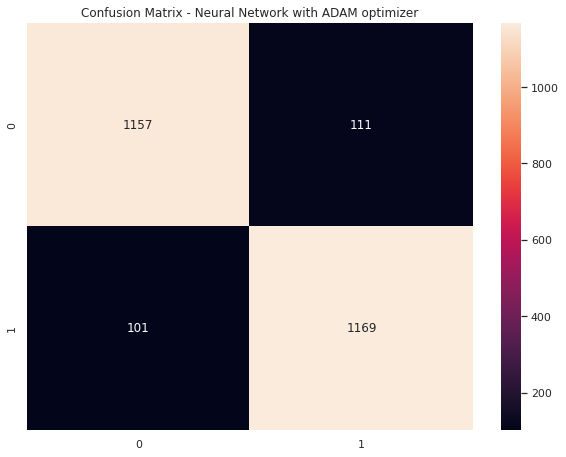

In [32]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', f1_metric, metrics.AUC()])
history_ann_adam = ann.fit(x_train, y_train, validation_data = (x_test,y_test), batch_size = 32, epochs = 100 , callbacks = [time_callback])

y_pred_adam = ann.predict(x_test)
y_pred_adam = (y_pred_adam > 0.5)

from sklearn.metrics import confusion_matrix, accuracy_score
cm_adam = confusion_matrix(y_test, y_pred_adam)
print(cm_adam)
accuracy_score(y_test, y_pred_adam)

ax1 = sn.heatmap(cm_adam, annot = True, fmt = 'd')
ax1.title.set_text('Confusion Matrix - Neural Network with ADAM optimizer')

print('Accuracy from Neural Network with ADAM optimizer', round(accuracy_score(y_test, y_pred_adam)*100, 4))

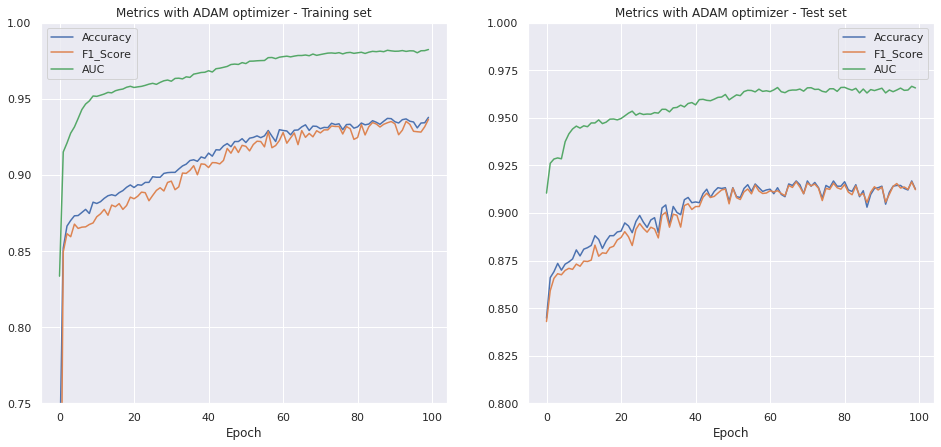

In [15]:
fig = plt.figure(figsize = (16, 7))
plt.subplot(1, 2, 1)
plt.plot(history_ann_adam.history['accuracy'])
plt.plot(history_ann_adam.history['f1_metric'])
plt.plot(history_ann_adam.history['auc'])
plt.title('Metrics with ADAM optimizer - Training set')
plt.xlabel('Epoch')
plt.ylim(0.75,1)
plt.legend(['Accuracy', 'F1_Score', 'AUC'])

plt.subplot(1, 2, 2)
plt.plot(history_ann_adam.history['val_accuracy'])
plt.plot(history_ann_adam.history['val_f1_metric'])
plt.plot(history_ann_adam.history['val_auc'])
plt.title('Metrics with ADAM optimizer - Test set')
plt.xlabel('Epoch')
plt.ylim(0.80,1)
plt.legend(['Accuracy', 'F1_Score', 'AUC'])
plt.show()

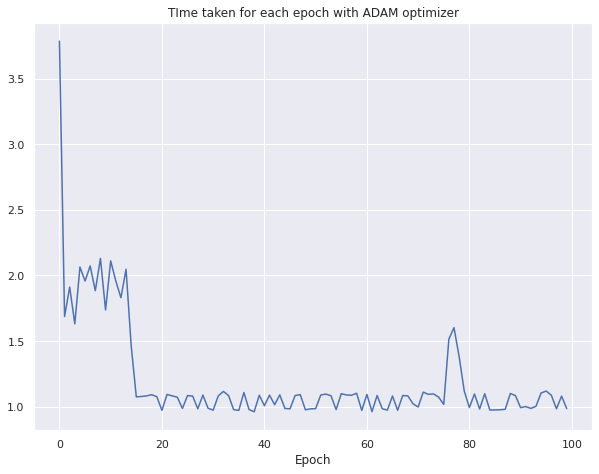

In [16]:
plt.plot(time_callback.times)
plt.title('TIme taken for each epoch with ADAM optimizer')
plt.xlabel('Time')
plt.xlabel('Epoch')
plt.show()

Epoch 1/100
186/186 [==============================] - 2s 7ms/step - loss: 0.1628 - accuracy: 0.9347 - f1_metric: 0.9334 - auc_1: 0.9818 - val_loss: 0.2459 - val_accuracy: 0.9165 - val_f1_metric: 0.9155 - val_auc_1: 0.9649
Epoch 2/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1610 - accuracy: 0.9377 - f1_metric: 0.9358 - auc_1: 0.9819 - val_loss: 0.2578 - val_accuracy: 0.9102 - val_f1_metric: 0.9092 - val_auc_1: 0.9643
Epoch 3/100
186/186 [==============================] - 1s 5ms/step - loss: 0.1617 - accuracy: 0.9340 - f1_metric: 0.9320 - auc_1: 0.9818 - val_loss: 0.2494 - val_accuracy: 0.9177 - val_f1_metric: 0.9167 - val_auc_1: 0.9668
Epoch 4/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1653 - accuracy: 0.9326 - f1_metric: 0.9264 - auc_1: 0.9816 - val_loss: 0.2522 - val_accuracy: 0.9090 - val_f1_metric: 0.9088 - val_auc_1: 0.9640
Epoch 5/100
186/186 [==============================] - 1s 5ms/step - loss: 0.1610 - accuracy: 0.9345 - f1_me

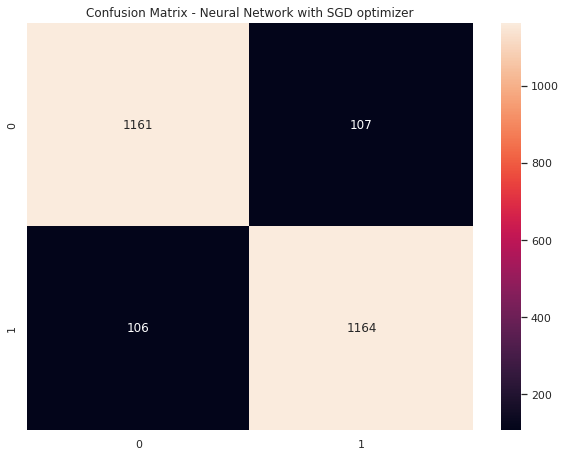

In [17]:
ann.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy', f1_metric, metrics.AUC()])
history_ann_sgd = ann.fit(x_train, y_train, validation_data = (x_test,y_test), batch_size = 32, epochs =  100, callbacks = [time_callback])

y_pred_sgd = ann.predict(x_test)
y_pred_sgd = (y_pred_sgd > 0.5)
from sklearn.metrics import confusion_matrix, accuracy_score
cm_sgd = confusion_matrix(y_test, y_pred_sgd)
print(cm_sgd)
accuracy_score(y_test, y_pred_sgd)

ax1 = sn.heatmap(cm_sgd, annot = True, fmt = 'd')
ax1.title.set_text('Confusion Matrix - Neural Network with SGD optimizer')

print('Accuracy from Neural Network with SGD optimizer', round(accuracy_score(y_test, y_pred_sgd)*100, 4))

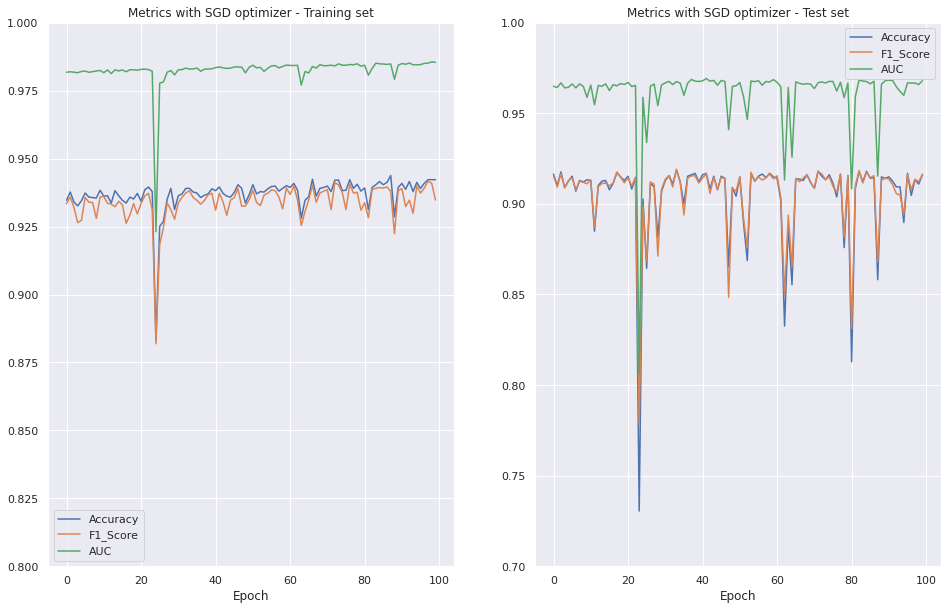

In [18]:
fig = plt.figure(figsize = (16, 10))
plt.subplot(1, 2, 1)
plt.plot(history_ann_sgd.history['accuracy'])
plt.plot(history_ann_sgd.history['f1_metric'])
plt.plot(history_ann_sgd.history['auc_1'])
plt.title('Metrics with SGD optimizer - Training set')
plt.xlabel('Epoch')
plt.ylim(0.80,1)
plt.legend(['Accuracy', 'F1_Score', 'AUC'])

plt.subplot(1, 2, 2)
plt.plot(history_ann_sgd.history['val_accuracy'])
plt.plot(history_ann_sgd.history['val_f1_metric'])
plt.plot(history_ann_sgd.history['val_auc_1'])
plt.title('Metrics with SGD optimizer - Test set')
plt.xlabel('Epoch')
plt.ylim(0.70,1)
plt.legend(['Accuracy', 'F1_Score', 'AUC'])
plt.show()

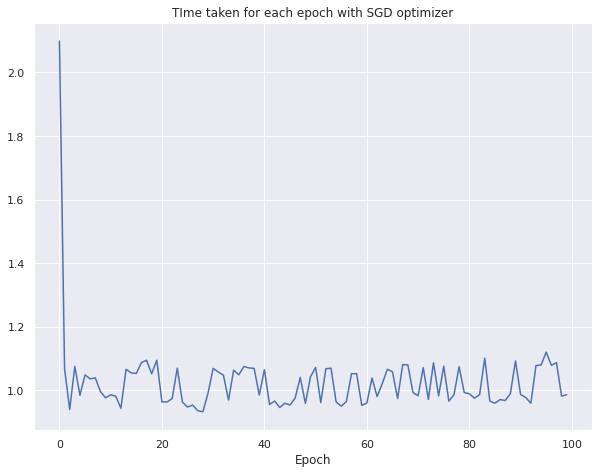

In [19]:
plt.plot(time_callback.times)
plt.title('TIme taken for each epoch with SGD optimizer')
plt.xlabel('Time')
plt.xlabel('Epoch')
plt.show()

Epoch 1/100
186/186 [==============================] - 3s 8ms/step - loss: 0.1455 - accuracy: 0.9421 - f1_metric: 0.9407 - auc_2: 0.9851 - val_loss: 0.2553 - val_accuracy: 0.9145 - val_f1_metric: 0.9151 - val_auc_2: 0.9665
Epoch 2/100
186/186 [==============================] - 1s 7ms/step - loss: 0.1434 - accuracy: 0.9397 - f1_metric: 0.9383 - auc_2: 0.9855 - val_loss: 0.2583 - val_accuracy: 0.9129 - val_f1_metric: 0.9135 - val_auc_2: 0.9663
Epoch 3/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1444 - accuracy: 0.9441 - f1_metric: 0.9377 - auc_2: 0.9851 - val_loss: 0.2548 - val_accuracy: 0.9102 - val_f1_metric: 0.9115 - val_auc_2: 0.9662
Epoch 4/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1440 - accuracy: 0.9424 - f1_metric: 0.9409 - auc_2: 0.9854 - val_loss: 0.2648 - val_accuracy: 0.9157 - val_f1_metric: 0.9142 - val_auc_2: 0.9664
Epoch 5/100
186/186 [==============================] - 1s 6ms/step - loss: 0.1433 - accuracy: 0.9439 - f1_me

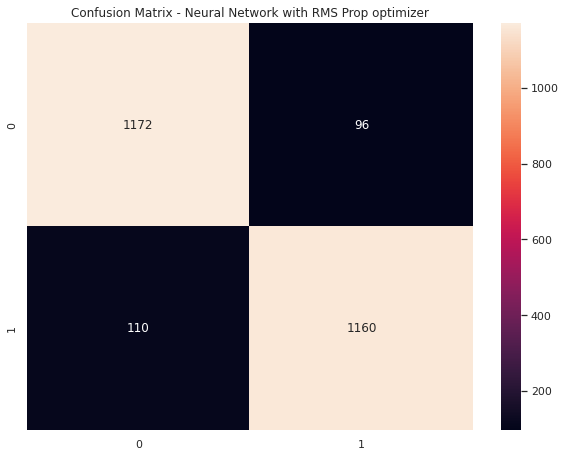

In [20]:
ann.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy', f1_metric, metrics.AUC()])
history_ann_rms = ann.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_data = (x_test,y_test), callbacks = [time_callback])
y_pred_rms = ann.predict(x_test)
y_pred_rms = (y_pred_rms > 0.5)
from sklearn.metrics import confusion_matrix, accuracy_score
cm_rms = confusion_matrix(y_test, y_pred_rms)
print(cm_rms)
accuracy_score(y_test, y_pred_rms)

ax1 = sn.heatmap(cm_rms, annot = True, fmt = 'd')
ax1.title.set_text('Confusion Matrix - Neural Network with RMS Prop optimizer')

print('Accuracy from Neural Network with RMS Prop optimizer', round(accuracy_score(y_test, y_pred_rms)*100, 4))

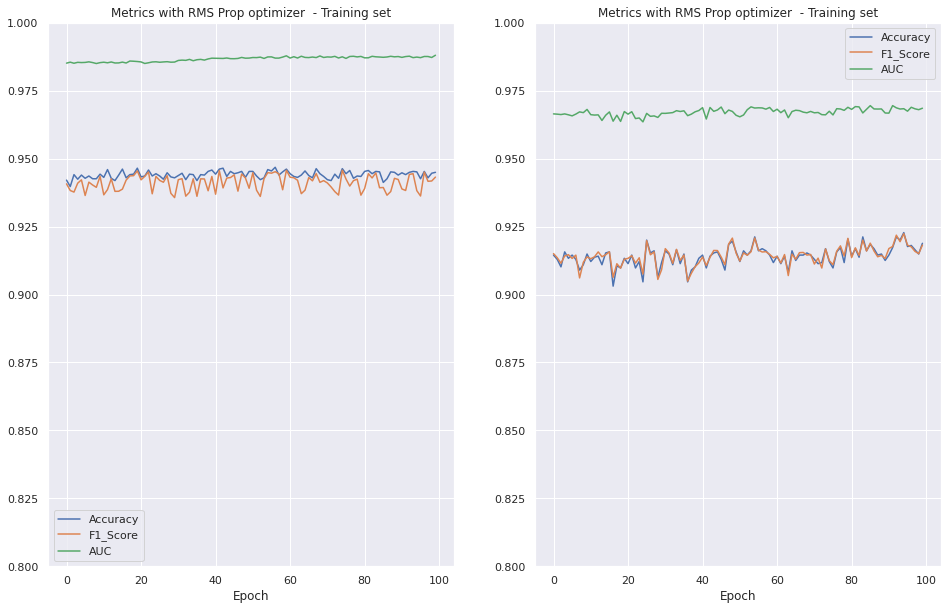

In [21]:
fig = plt.figure(figsize = (16, 10))
plt.subplot(1, 2, 1)
plt.plot(history_ann_rms.history['accuracy'])
plt.plot(history_ann_rms.history['f1_metric'])
plt.plot(history_ann_rms.history['auc_2'])
plt.title('Metrics with RMS Prop optimizer  - Training set')
plt.xlabel('Epoch')
plt.ylim(0.80,1)
plt.legend(['Accuracy', 'F1_Score', 'AUC'])

plt.subplot(1, 2, 2)
plt.plot(history_ann_rms.history['val_accuracy'])
plt.plot(history_ann_rms.history['val_f1_metric'])
plt.plot(history_ann_rms.history['val_auc_2'])
plt.title('Metrics with RMS Prop optimizer  - Training set')
plt.xlabel('Epoch')
plt.ylim(0.80,1)
plt.legend(['Accuracy', 'F1_Score', 'AUC'])
plt.show()

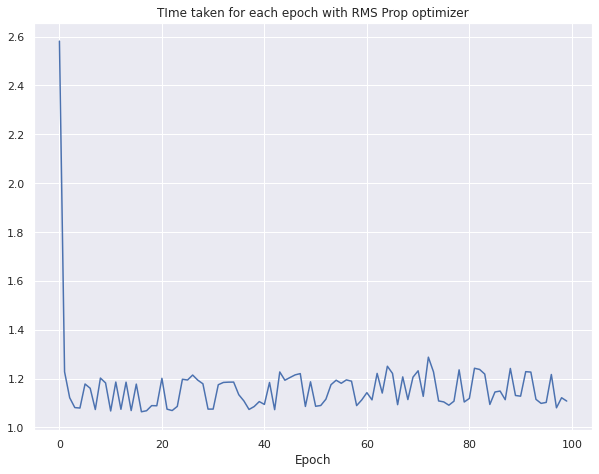

In [22]:
plt.plot(time_callback.times)
plt.title('TIme taken for each epoch with RMS Prop optimizer')
plt.xlabel('Time')
plt.xlabel('Epoch')
plt.show()

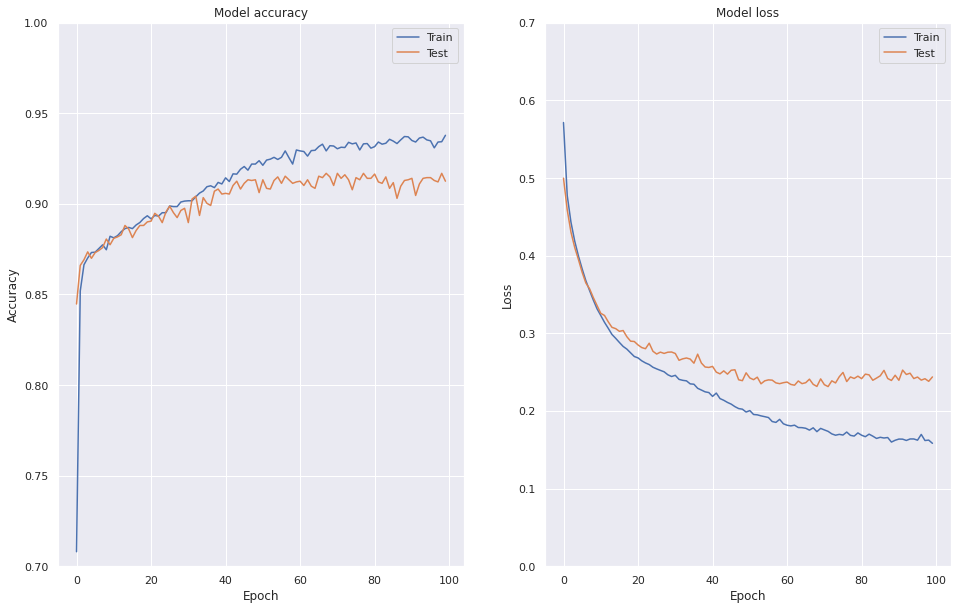

In [23]:
fig = plt.figure(figsize = (16, 10))
plt.subplot(1, 2, 1)
plt.plot(history_ann_adam.history['accuracy'])
plt.plot(history_ann_adam.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.70,1)
plt.legend(['Train', 'Test'])

plt.subplot(1, 2, 2)
plt.plot(history_ann_adam.history['loss']) 
plt.plot(history_ann_adam.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.ylim(0, 0.7)
plt.legend(['Train', 'Test']) 
plt.show()

In [24]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1234)
cvscores = []
for train, test in kfold.split(x, y):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units = 14, input_dim = 14,  activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 15, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 12, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 5, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(x_train, y_train, epochs = 100, batch_size = 32)
  scores = model.evaluate(x_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
 

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6020 - accuracy: 0.7055
Epoch 2/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4758 - accuracy: 0.8622
Epoch 3/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4420 - accuracy: 0.8683
Epoch 4/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4193 - accuracy: 0.8681
Epoch 5/100
186/186 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.8693
Epoch 6/100
186/186 [==============================] - 1s 3ms/step - loss: 0.3821 - accuracy: 0.8744
Epoch 7/100
186/186 [==============================] - 1s 3ms/step - loss: 0.3655 - accuracy: 0.8750
Epoch 8/100
186/186 [==============================] - 1s 3ms/step - loss: 0.3516 - accuracy: 0.8793
Epoch 9/100
186/186 [==============================] - 1s 3ms/step - loss: 0.3416 - accuracy: 0.8791
Epoch 10/100
186/186 [==============================] - 1s 3ms/step - loss: 0.3282 - accura

In [25]:
print('CV Scores list:', cvscores)

CV Scores list: [91.60756468772888, 91.33175611495972, 91.76517128944397, 91.56816601753235, 91.4893627166748, 91.37116074562073, 91.68636798858643, 91.4499580860138, 91.8045699596405, 91.76517128944397]


In [26]:
test_set_sizes = [0.2, 0.3, 0.4, 0.5]
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for i in range(len(test_set_sizes)):
  ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = ann.fit(x_train, y_train, validation_split = test_set_sizes[i], epochs = 100, batch_size = 32)
  train_accuracy.append(history.history['accuracy'])
  val_accuracy.append(history.history['val_accuracy'])
  train_loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])

Epoch 1/100
149/149 [==============================] - 1s 6ms/step - loss: 0.1380 - accuracy: 0.9457 - val_loss: 0.1379 - val_accuracy: 0.9443
Epoch 2/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1389 - accuracy: 0.9441 - val_loss: 0.1411 - val_accuracy: 0.9477
Epoch 3/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1307 - accuracy: 0.9468 - val_loss: 0.1523 - val_accuracy: 0.9392
Epoch 4/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1282 - accuracy: 0.9489 - val_loss: 0.1458 - val_accuracy: 0.9367
Epoch 5/100
149/149 [==============================] - 1s 3ms/step - loss: 0.1287 - accuracy: 0.9479 - val_loss: 0.1521 - val_accuracy: 0.9376
Epoch 6/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1306 - accuracy: 0.9483 - val_loss: 0.1721 - val_accuracy: 0.9359
Epoch 7/100
149/149 [==============================] - 1s 4ms/step - loss: 0.1303 - accuracy: 0.9455 - val_loss: 0.1486 - val_accuracy: 0.9409

In [27]:
train_accuracy = pd.DataFrame(train_accuracy).T
train_accuracy.rename(columns = {0:0.2, 1:0.3, 2:0.4, 3:0.5}, inplace = True)

val_accuracy = pd.DataFrame(val_accuracy).T 
val_accuracy.rename(columns = {0:0.2, 1:0.3, 2:0.4, 3:0.5}, inplace = True)

train_loss = pd.DataFrame(train_loss).T
train_loss.rename(columns = {0:0.2, 1:0.3, 2:0.4, 3:0.5}, inplace = True)

val_loss = pd.DataFrame(val_loss).T
val_loss.rename(columns = {0:0.2, 1:0.3, 2:0.4, 3:0.5}, inplace = True)

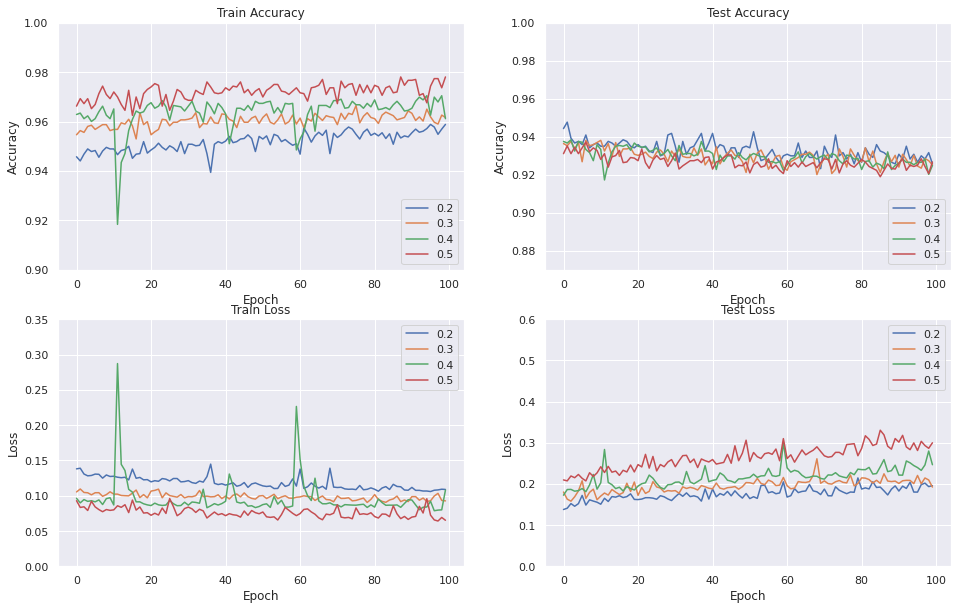

In [30]:
import matplotlib.pylab as ply
fig = plt.figure(figsize = (16, 10))
plt.subplot(2, 2, 1)
ply.plot(train_accuracy)
ply.legend(test_set_sizes, loc = 'lower right')
ply.title('Train Accuracy')
ply.xlabel('Epoch')
ply.ylabel('Accuracy')
ply.ylim(0.90, 1)

plt.subplot(2, 2, 2)
ply.plot(val_accuracy, linestyle = '-')
ply.legend(test_set_sizes, loc = 'lower right')
ply.title('Test Accuracy')
ply.xlabel('Epoch')
ply.ylabel('Accuracy')
ply.ylim(0.87, 1)

plt.subplot(2, 2, 3)
ply.plot(train_loss)
ply.legend(test_set_sizes, loc = 'upper right')
ply.title('Train Loss')
ply.xlabel('Epoch')
ply.ylabel('Loss')
ply.ylim(0, 0.35)

plt.subplot(2, 2, 4)
ply.plot(val_loss)
ply.legend(test_set_sizes, loc = 'upper right')
ply.title('Test Loss')
ply.xlabel('Epoch')
ply.ylabel('Loss')
ply.ylim(0, 0.6)
ply.show()

In [29]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units = 14, input_dim = 14,  activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 15, activation = 'leaky_relu'))
ann.add(tf.keras.layers.Dense(units = 12, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 10, activation = 'leaky_relu'))
ann.add(tf.keras.layers.Dense(units = 5, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', f1_metric, metrics.AUC()])
history_ann_act = ann.fit(x_train, y_train, validation_data = (x_test,y_test), batch_size = 32, epochs =  100)

y_pred_act = ann.predict(x_test)
y_pred_act = (y_pred_act > 0.5)
from sklearn.metrics import confusion_matrix, accuracy_score
cm_act = confusion_matrix(y_test, y_pred_act)
print(cm_act)
accuracy_score(y_test, y_pred_act)


Epoch 1/100
186/186 [==============================] - 2s 7ms/step - loss: 0.5009 - accuracy: 0.7685 - f1_metric: 0.7959 - auc_3: 0.8769 - val_loss: 0.3403 - val_accuracy: 0.8664 - val_f1_metric: 0.8553 - val_auc_3: 0.9297
Epoch 2/100
186/186 [==============================] - 1s 5ms/step - loss: 0.3173 - accuracy: 0.8639 - f1_metric: 0.8503 - auc_3: 0.9365 - val_loss: 0.3024 - val_accuracy: 0.8652 - val_f1_metric: 0.8625 - val_auc_3: 0.9424
Epoch 3/100
186/186 [==============================] - 1s 6ms/step - loss: 0.2976 - accuracy: 0.8727 - f1_metric: 0.8644 - auc_3: 0.9438 - val_loss: 0.2906 - val_accuracy: 0.8802 - val_f1_metric: 0.8715 - val_auc_3: 0.9467
Epoch 4/100
186/186 [==============================] - 1s 6ms/step - loss: 0.2862 - accuracy: 0.8715 - f1_metric: 0.8569 - auc_3: 0.9475 - val_loss: 0.2859 - val_accuracy: 0.8846 - val_f1_metric: 0.8758 - val_auc_3: 0.9483
Epoch 5/100
186/186 [==============================] - 1s 6ms/step - loss: 0.2800 - accuracy: 0.8744 - f1_me

0.9211977935382191